In [1]:
import pandas as pd
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Helper only for grouping similar names, not renaming
def normalize_key(col):
    c = col.strip().lower()
    c = c.replace("_", "").replace("-", "").replace(" ", "")
    return c

# List all CSV files
csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]

# Read files
dataframes = {file: pd.read_csv(file) for file in csv_files}

# Mapping: normalized_key -> set(raw spellings)
normalized_to_raw = {}
for file, df in dataframes.items():
    for raw_col in df.columns:
        key = normalize_key(raw_col)
        if key not in normalized_to_raw:
            normalized_to_raw[key] = set()
        normalized_to_raw[key].add(raw_col)

# Full normalized column set
all_normalized_cols = set(normalized_to_raw.keys())

# Summary collectors
summary_missing = {}
summary_spelling = {}
summary_duplicates = {}      # <-- NEW
summary_row_counts = {}      # optional but useful
summary_column_counts = {}   # optional but useful

# Main loop
for file, df in dataframes.items():
    print(f"\n### {file}\n")

    row_count = len(df)
    col_count = len(df.columns)

    summary_row_counts[file] = row_count
    summary_column_counts[file] = col_count

    print(f"Number of rows: {row_count}")
    print(f"Number of columns: {col_count}")

    # Spelling issues
    spelling_issues = []
    for raw_col in df.columns:
        key = normalize_key(raw_col)
        variants = normalized_to_raw.get(key, set())
        other_spellings = sorted(list(variants - {raw_col}))
        if other_spellings:
            spelling_issues.append((raw_col, other_spellings))

    if spelling_issues:
        print("\nColumns with different spellings in other files:")
        for raw, others in spelling_issues:
            print(f"  This file uses '{raw}', others use: {others}")
        summary_spelling[file] = spelling_issues
    else:
        print("\nNo spelling differences for this file.")

    # Missing columns check
    file_norm_keys = {normalize_key(c) for c in df.columns}
    missing_keys = all_normalized_cols - file_norm_keys

    if missing_keys:
        print("\nColumns missing from this file:")
        missing_list = []
        for key in missing_keys:
            print(f"  Missing logical column '{key}' represented in other files as: {list(normalized_to_raw[key])}")
            missing_list.append(key)
        summary_missing[file] = missing_list
    else:
        print("\nNo missing columns for this file.")

    # Head
    print("\nHead:")
    print(df.head().to_markdown(index=False))

    # Info
    print("\nData Types / Info:")
    df.info()
    print()

    # Describe
    print("Describe:")
    try:
        print(df.describe().to_markdown())
    except:
        print("No numeric columns to describe.")

    # Duplicates
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"\nDuplicate rows: {dup_count}")
        summary_duplicates[file] = dup_count
    else:
        print("\nNo duplicate rows.")

# ================================
# FINAL SUMMARY REPORT
# ================================

print("\n\n================ FINAL SUMMARY ================\n")

# Row count summary
print("Row Counts per File:")
for file, count in summary_row_counts.items():
    print(f"- {file}: {count} rows")

print("\nColumn Counts per File:")
for file, count in summary_column_counts.items():
    print(f"- {file}: {count} columns")

# Missing columns summary
print("\n\nFiles Missing Columns:")
if summary_missing:
    for file, missing in summary_missing.items():
        detailed = {key: list(normalized_to_raw[key]) for key in missing}
        print(f"- {file} → missing: {detailed}")
else:
    print("None")

# Spelling difference summary
print("\nFiles With Spelling Differences:")
if summary_spelling:
    for file, issues in summary_spelling.items():
        print(f"- {file}:")
        for raw, others in issues:
            print(f"    '{raw}' differs from: {others}")
else:
    print("None")

# Duplicate summary  <-- NEW
print("\nFiles With Duplicate Rows:")
if summary_duplicates:
    for file, dups in summary_duplicates.items():
        print(f"- {file}: {dups} duplicate rows")
else:
    print("No duplicate rows found in any file.")

print("\n=============== END OF SUMMARY ===============")



### events_20250223.csv

Number of rows: 4070
Number of columns: 7

Columns with different spellings in other files:
  This file uses 'client_id', others use: ['clientId']

No missing columns for this file.

Head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------|:-------------------------|:-------------|-------------:|:--

In [2]:
# Known issues from Step 0
files_with_clientId = [
    'events_20250227.csv', 'events_20250228.csv', 'events_20250301.csv',
    'events_20250302.csv', 'events_20250303.csv', 'events_20250304.csv',
    'events_20250305.csv', 'events_20250306.csv', 'events_20250307.csv',
    'events_20250308.csv'
]

files_missing_referrer = [
    'events_20250304.csv', 'events_20250305.csv', 'events_20250306.csv',
    'events_20250307.csv', 'events_20250308.csv'
]

duplicate_file = "events_20250308.csv"

cleaned_files = {}
csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]

all_columns_standardized = None

for file in csv_files:
    df = pd.read_csv(file)
    print(f"\n\n==================== Cleaning {file} ====================")

    # Fix known spelling issue
    if file in files_with_clientId and "clientId" in df.columns:
        df.rename(columns={"clientId": "client_id"}, inplace=True)
        print("Corrected spelling: clientId to client_id")

    # Add missing referrer column
    if file in files_missing_referrer and "referrer" not in df.columns:
        df["referrer"] = None
        print("Added missing column: referrer")

    # Remove duplicates
    if file == duplicate_file:
        before = len(df)
        df = df.drop_duplicates()
        after = len(df)
        print(f"Rows before duplicate removal: {before}")
        print(f"Rows after duplicate removal:  {after}")

    # Collect unified schema
    if all_columns_standardized is None:
        all_columns_standardized = set(df.columns)
    else:
        all_columns_standardized.update(df.columns)

    # Print head
    print("\nHead:")
    print(df.head().to_markdown(index=False))

    # Print info
    print("\nInfo:")
    df.info()
    print()

    cleaned_files[file] = df

# Schema verification
print("\n\n==================== SCHEMA VERIFICATION ====================\n")

print("Unified schema after fixes:")
print(sorted(all_columns_standardized))
print()

for file, df in cleaned_files.items():
    print(f"\n--- {file} ---")

    # Column count
    print(f"Column count: {len(df.columns)}")

    # Missing columns check
    missing = all_columns_standardized - set(df.columns)
    if missing:
        print(f"Missing columns: {missing}")
    else:
        print("All required columns are present")

    # Incorrect spelling check
    wrong_names = [c for c in df.columns if c.lower() == "clientid"]
    if wrong_names:
        print(f"Incorrect column names still present: {wrong_names}")
    else:
        print("No incorrect column names remain")

print("\nSchema verification is complete.\n")




==================== Cleaning events_20250223.csv ====================

Head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------|:-------------------------|:-------------|-------------:|:-----------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Step 2: Merge all cleaned DataFrames and clean nulls

required_cols = ["client_id", "timestamp", "event_name"]

# merge all cleaned DataFrames from previous step
merged_df = pd.concat(cleaned_files.values(), ignore_index=True)

print("Total rows before null cleaning:", len(merged_df))

print("\nNull counts in required columns:")
print(merged_df[required_cols].isnull().sum())

# drop rows with nulls in required critical columns
cleaned_merged_df = merged_df.dropna(subset=required_cols)

print("\nTotal rows after removing nulls:", len(cleaned_merged_df))

# duplicate check AFTER merge
dup_count_before = cleaned_merged_df.duplicated().sum()
print("\nDuplicate rows detected after merge (before removal):", dup_count_before)

if dup_count_before > 0:
    rows_before = len(cleaned_merged_df)
    cleaned_merged_df = cleaned_merged_df.drop_duplicates()
    rows_after = len(cleaned_merged_df)
    dup_count_after = cleaned_merged_df.duplicated().sum()

    print("Rows before duplicate removal:", rows_before)
    print("Rows after duplicate removal:", rows_after)
    print("Duplicate rows detected after removal:", dup_count_after)
else:
    print("No duplicate rows found after merge.")

# preview
print("\nHead of merged cleaned dataset:")
print(cleaned_merged_df.head().to_markdown(index=False))

print("\nInfo after cleaning:")
cleaned_merged_df.info()
print()

# save output for next steps
cleaned_merged_df.to_csv("events_merged_cleaned.csv", index=False)
print("Merged and cleaned dataset saved as events_merged_cleaned.csv")



Total rows before null cleaning: 97016

Null counts in required columns:
client_id     2908
timestamp        0
event_name       0
dtype: int64

Total rows after removing nulls: 94108

Duplicate rows detected after merge (before removal): 47054
Rows before duplicate removal: 94108
Rows after duplicate removal: 47054
Duplicate rows detected after removal: 0

Head of merged cleaned dataset:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------

In [4]:
from urllib.parse import urlparse, parse_qs
import json

# Work directly on cleaned_merged_df
df = cleaned_merged_df

print("Starting Step 3: Splitting timestamp and inspecting parameters...\n")

# 1) Convert timestamp and extract new time columns
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

df["event_date"] = df["timestamp"].dt.date
df["event_time"] = df["timestamp"].dt.time
df["event_hour"] = df["timestamp"].dt.hour
df["event_weekday"] = df["timestamp"].dt.day_name()

print("Timestamp successfully split into event_date, event_time, event_hour, event_weekday.\n")

# 2) Inspect URL query parameters
print("Inspecting all URL parameters present in page_url...\n")

all_url_params = set()

for url in df["page_url"].astype(str):
    query = parse_qs(urlparse(url).query)
    for p in query.keys():
        all_url_params.add(p)

print("Detected URL parameters:")
print(all_url_params)
print("Total parameters detected:", len(all_url_params), "\n")

# 3) Inspect event_data JSON keys
print("Inspecting keys inside event_data...\n")

event_keys = set()

for raw in df["event_data"].astype(str):
    try:
        obj = json.loads(raw)
        for key in obj.keys():
            event_keys.add(key)
    except:
        continue

print("Detected event_data keys:")
print(event_keys)
print("Total keys detected:", len(event_keys), "\n")

# 4) Inspect user_agent examples
print("Sample user_agent values:")
print(df["user_agent"].head(5), "\n")

# 5) Confirm datatypes after timestamp conversion
print("Data types after timestamp and inspection:")
df.info()

print("\nStep 3 inspection complete. No extraction or row removals performed.")


Starting Step 3: Splitting timestamp and inspecting parameters...

Timestamp successfully split into event_date, event_time, event_hour, event_weekday.

Inspecting all URL parameters present in page_url...

Detected URL parameters:
{'step', 'auto_show_edge_shopping_flyout', 'locale', 'ml___id', 'cto_pld', 'product', 'main', 'imp_sku', 'sn', 'bedframe', 'srsltid', 'gad', 'gclid', 'ny', '_rsc', '_ke', 'clickid', 'gqt', 'utm_campaign', 'variation', 'button', 'epik', 'awc', 'im_rewards', 'utm_term', 'sleepingPosition', '_kx', 'preview_theme_id', 'amp_device_id', 'talkable_visitor_uuid', 'kind', 'sub4', 'country', 'wtbap', 'irclickid', 'set_view', 'msclkid', 'optimizely_x_audiences', 'page', 'utm_medium', 'com_cvv', 'gad_source', 'optimizely_x', 'optimizely_token', 'ad_id', 'completed', 'c_token', 'view', 'variant', 'edge_redirect', 'offer', 'optimizely_preview_layer_ids', 'su', 'ml___url_share_action', 'rf', 'subid1', 'ml___task', 'reload_receipt', '2', 'bxid', 'mattress', 'color', 'media_

In [5]:
import re
import json
from urllib.parse import urlparse, parse_qs

print("Starting Step 4: Extracting URL params, JSON fields, items, UA parts, browser, and item dimensions...\n")

# ------------------------------------------------------
# 0) Work on a clean copy
# ------------------------------------------------------
df_ext = cleaned_merged_df.copy()


# ======================================================
# 1) JSON SANITIZATION HELPERS
# ======================================================

def clean_json_string(raw):
    """Cleans malformed JSON input by removing parentheses and semicolons."""
    if raw is None:
        return None
    s = str(raw).strip()

    if s.startswith("(") and s.endswith(")"):
        s = s[1:-1].strip()
    if s.endswith(";"):
        s = s[:-1].strip()

    return s


def load_json(raw):
    """Safe JSON loading after sanitization."""
    try:
        cleaned = clean_json_string(raw)
        return json.loads(cleaned)
    except:
        return None


# ======================================================
# 2) URL PARAMETER EXTRACTION
# ======================================================
utm_params = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]
ad_params = ["gclid", "fbclid", "msclkid", "wbraid", "gbraid"]
product_params = ["product", "mattress", "feel", "size", "color", "variant"]
checkout_params = ["cart_id", "checkout_queue_token"]

all_url_params = utm_params + ad_params + product_params + checkout_params

def extract_param(url, key):
    try:
        return parse_qs(urlparse(str(url)).query).get(key, [None])[0]
    except:
        return None

# extract all except product (handled separately)
for p in all_url_params:
    if p == "product":
        continue
    df_ext[p] = df_ext["page_url"].apply(lambda x: extract_param(x, p))


# ======================================================
# 2B) CORRECT PRODUCT SLUG FROM URL PATH
# ======================================================
def extract_product_from_url(url):
    if not isinstance(url, str):
        return None

    u = url.lower()

    if "/products/" not in u:
        return None

    slug = u.split("/products/")[1]
    slug = slug.split("?")[0]
    slug = slug.split("/")[0]
    slug = re.sub(r'[^a-zA-Z0-9\-\_]', "", slug)

    return slug if slug else None

df_ext["product"] = df_ext["page_url"].apply(extract_product_from_url)


# ======================================================
# 3) EVENT-LEVEL JSON FIELDS
# ======================================================
event_fields = ["transaction_id", "user_email", "revenue", "items"]

for f in event_fields:
    df_ext[f] = df_ext["event_data"].apply(
        lambda x: load_json(x).get(f) if load_json(x) else None
    )


# ======================================================
# 4) ITEM-LEVEL EXTRACTION
# ======================================================
item_fields = ["item_id", "item_name", "item_variant", "quantity", "item_price"]

def extract_item_field(raw, key):
    obj = load_json(raw)
    if not obj:
        return None

    items = obj.get("items")
    if isinstance(items, list) and len(items) > 0:
        return items[0].get(key)

    return None

for col in item_fields:
    df_ext[col] = df_ext["event_data"].apply(lambda x: extract_item_field(x, col))


# ======================================================
# 4B) SPLIT item_variant INTO TYPE, SIZE, WIDTH, LENGTH, HEIGHT
# ======================================================
def parse_item_variant(v):
    if not isinstance(v, str):
        return (None, None, None, None, None)

    # Extract type and size from the left part
    variant_main = v.split("-")[0].strip()
    if "/" in variant_main:
        item_type = variant_main.split("/")[0].strip()
        item_size = variant_main.split("/")[1].strip()
    else:
        item_type = None
        item_size = None

    # Extract dimensions allowing decimals (critical fix)
    width_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Ww]', v)
    length_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Ll]', v)
    height_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Hh]', v)

    width = width_match.group(1) if width_match else None
    length = length_match.group(1) if length_match else None
    height = height_match.group(1) if height_match else None  # FIXED

    return (item_type, item_size, width, length, height)

df_ext[["item_type", "item_size", "dim_width_in", "dim_length_in", "dim_height_in"]] = \
    df_ext["item_variant"].apply(lambda x: pd.Series(parse_item_variant(x)))


# ======================================================
# 5) USER-AGENT TOKEN SPLITTING
# ======================================================
def clean_ua_token(token):
    if token is None:
        return None
    t = str(token).strip()

    t = re.sub(r'^[\(\[\{\"\'\s]+', "", t)
    t = re.sub(r'[\)\]\}\"\'\;\,\s]+$', "", t)

    return t

ua_split = df_ext["user_agent"].astype(str).str.split(" ")

df_ext["ua_part1"] = ua_split.str[0].apply(clean_ua_token)
df_ext["ua_part2"] = ua_split.str[1].apply(clean_ua_token)
df_ext["ua_part3"] = ua_split.str[2].apply(clean_ua_token)


# ======================================================
# 6) CLEAN BROWSER IDENTIFICATION
# ======================================================
def extract_clean_browser(ua):
    if not isinstance(ua, str):
        return None

    ua_l = ua.lower()

    if "chrome/" in ua_l and "edg/" not in ua_l:
        return "Chrome"
    if "safari/" in ua_l and "chrome/" not in ua_l:
        return "Safari"
    if "firefox/" in ua_l:
        return "Firefox"
    if "edg/" in ua_l:
        return "Edge"
    if "ddg" in ua_l or "duckduckgo" in ua_l:
        return "DuckDuckGo"
    if "opr/" in ua_l or "opera" in ua_l:
        return "Opera"

    return "Other"

df_ext["browser"] = df_ext["user_agent"].apply(extract_clean_browser)


# ======================================================
# 7) PREVIEW
# ======================================================
print(df_ext.head(100).to_markdown(index=False))

print("\nData types after extraction:")
df_ext.info()

print("\nStep 4 complete: All fields extracted successfully, including corrected height parsing.\n")




Starting Step 4: Extracting URL params, JSON fields, items, UA parts, browser, and item dimensions...

| client_id               | page_url                                                                                                                                                                                                                                                                                                                            | referrer                                                                                                        | timestamp                        | event_name            | event_data                                                                                                                                                                                                                                                                                                   | user_agent                                                         

In [6]:
# Step 5: Rename UA parts + ad ids + product fields directly on df_ext

rename_map = {
    # User-Agent meaningful names
    "ua_part1": "ua_engine",          # e.g., Mozilla/5.0
    "ua_part2": "ua_device_token",    
    "ua_part3": "ua_os_token",       

    # Ad identifiers
    "gclid": "google_click_id",
    "fbclid": "facebook_click_id",
    "msclkid": "microsoft_click_id",
    "wbraid": "google_wbraid",
    "gbraid": "google_gbraid",

    # Product / merchandising parameters
    "product": "product_type",
    "mattress": "mattress_type",
    "feel": "product_feel",
    "size": "product_size",
    "color": "product_color",
    "variant": "product_variant",

    # Checkout identifiers
    "cart_id": "checkout_cart_id",
    "checkout_queue_token": "checkout_queue_token",

    # Event-level JSON fields
    "transaction_id": "transaction_id",
    "user_email": "user_email",
    "revenue": "revenue",
    "items": "items",

    # Item-level extracted fields
    "item_id": "item_id",
    "item_name": "item_name",
    "item_variant": "item_variant",
    "quantity": "item_quantity",
    "item_price": "item_price",

    # Browser column
    "browser": "browser"
}

# Apply renaming directly
df_ext.rename(columns=rename_map, inplace=True)

# PREVIEW
print("### df_ext head (first 10 rows):")
print(df_ext.head(10).to_markdown(index=False))

print("\n### df_ext.info():")
df_ext.info()


### df_ext head (first 10 rows):
| client_id               | page_url                                                                                                                                                                                                                                                                      | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date   | event_time      |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type           | transaction_id   |

In [7]:
# Step 6: Categorical Sampling for Unification Check

categorical_cols = [
    "product_type", 
    "product_feel",
    "product_size",
    "product_color",
    "product_variant",
    "user_email",
    "item_name",
    "item_variant",
    "event_name",
    "event_data",
    "ua_os_token",
    "browser",
    "ua_device_token",
    "ua_engine"
]

print("\nStarting Step 6: Categorical Sampling...\n")

for col in categorical_cols:
    if col not in df_ext.columns:
        print(f"\nColumn '{col}' not found in df_ext — skipping.")
        continue

    print(f"\n==============================")
    print(f"Categorical Sampling for: {col}")
    print("==============================")

    unique_vals = df_ext[col].dropna().unique()
    unique_count = len(unique_vals)

    print(f"Total unique values: {unique_count}")

    if unique_count > 50:
        top50 = (
            df_ext[col]
            .value_counts(dropna=True)
            .head(50)
            .index
            .tolist()
        )
        print("Top 50 most frequent values:")
        print(top50)
    else:
        print("All unique values:")
        print(unique_vals)



Starting Step 6: Categorical Sampling...


Categorical Sampling for: product_type
Total unique values: 39
All unique values:
['puffy-mattress' 'puffy-topper' 'puffy-lux-mattress'
 'puffy-monarch-mattress' 'puffy-bed-frame' 'puffy-adjustable-base'
 'puffy-royal-mattress' 'puffy-blanket' 'puffy-sheets'
 'puffy-zen-bed-frame' 'puffy-foundation' 'puffy-monarch-smart-bed-set'
 'puffy-pillow' 'puffy-lux-smart-bed-set' 'puffy-weighted-blanket'
 'puffy-mattress-protector' 'puffy-dusk-bed-frame'
 'puffy-mattress-vs-purple' 'puffy-comforter' 'puffy-cloud-smart-bed-set'
 'puffy-royal-smart-bed-set' 'puffy-mattress-pad' 'puffy-sectional-sofa'
 'puffy-area-rug' 'puffy-royal-mattresss' 'puffy-sleep-mask'
 'puffy-lux-mattress_kx4bqho-f4gydddatvsbwtzqkn3hwrkindback-pain'
 'puffy-cloud-mattress-cooling'
 'puffy-mattress_kxiq1dyvavnr1e9hqev7xqpezrp3s6atp6qqwja0594dukn3hwr'
 'puffy-lux-mattress_kxzwvxhwsxs_rte8ftyghjwy0he9zyjjouae8jnsabtu0kn3hwr'
 'puffy-lux-mattress_kxckfeyttkeuqe9ckw9xeihmevu-_xieiswo

In [8]:
print("\nStarting Step 5: Category Unification...\n")

# =========================================================
# 1) PRODUCT TYPE CLEANING  (use the correct column name!)
# =========================================================

valid_products = {
    "puffy-mattress", "puffy-lux-mattress", "puffy-monarch-mattress",
    "puffy-royal-mattress", "puffy-topper", "puffy-blanket",
    "puffy-weighted-blanket", "puffy-sheets", "puffy-pillow",
    "puffy-comforter", "puffy-mattress-protector", "puffy-mattress-pad",
    "puffy-bed-frame", "puffy-zen-bed-frame", "puffy-dusk-bed-frame",
    "puffy-foundation", "puffy-adjustable-base", "puffy-sectional-sofa",
    "puffy-area-rug", "puffy-cloud-mattress", "puffy-cloud-smart-bed-set",
    "puffy-monarch-smart-bed-set", "puffy-lux-smart-bed-set",
    "puffy-royal-smart-bed-set", "puffy-signature-sleep-mask",
    "puffy-deluxe-mattress-pad", "cover-puffy-lux"
}

def clean_product_type(p):
    if p is None or str(p).lower() == "nan":
        return None

    p = str(p).lower().strip()

    # Remove hash suffix like: puffy-lux-mattress_kx92d0...
    if "_" in p:
        p = p.split("_")[0]

    # Fix typos
    if p == "puffy-royal-mattresss":
        return "puffy-royal-mattress"
    if p == "puffy-monarch-mattress22":
        return "puffy-monarch-mattress"

    # We treat weird slugs pointing to blogs/content pages
    if "vs" in p or "review" in p or "comparison" in p:
        return "content-page"

    if p in valid_products:
        return p

    return "unknown_product"

df_ext["product_type_clean"] = df_ext["product_type"].apply(clean_product_type)


# =========================================================
# 2) OS TOKEN NORMALIZATION
# =========================================================

def clean_os_token(os):
    if os is None:
        return "Other"
    os = str(os).strip()

    mapping = {
        "NT": "Windows",
        "CPU": "iOS",
        "Intel": "macOS",
        "Android": "Android",
        "Linux": "Linux",
        "Ubuntu": "Linux",
        "CrOS": "ChromeOS",
        "NetCast": "SmartTV",
        "PlayStation": "PlayStationOS"
    }

    return mapping.get(os, "Other")

df_ext["ua_os_clean"] = df_ext["ua_os_token"].apply(clean_os_token)


# =========================================================
# 3) DEVICE TOKEN NORMALIZATION
# =========================================================

def clean_device_token(dev):
    if dev is None:
        return "Other"
    dev = str(dev).strip()

    mapping = {
        "iPhone": "iPhone",
        "iPad": "iPad",
        "Macintosh": "Mac",
        "Windows": "Windows",
        "Android": "Android",
        "Linux": "Linux",
        "X11": "Linux Desktop",
        "Mobile": "Mobile",
        "SMART-TV": "SmartTV",
        "PlayStation": "PlayStation"
    }

    return mapping.get(dev, "Other")

df_ext["ua_device_clean"] = df_ext["ua_device_token"].apply(clean_device_token)


# =========================================================
# 4) ENGINE TOKEN NORMALIZATION
# =========================================================

def clean_engine_token(e):
    if e is None:
        return "Other"

    e = str(e).strip()

    mapping = {
        "Mozilla/5.0": "Mozilla",
        "facebookexternalhit/1.1": "FacebookBot",
        "Instagram": "InstagramBot",
        "AdsBot-Google": "GoogleAdsBot",
        "msnbot/1.1": "MSNBot"
    }

    return mapping.get(e, "Other")

df_ext["ua_engine_clean"] = df_ext["ua_engine"].apply(clean_engine_token)


# =========================================================
# 5) PREVIEW
# =========================================================

print("Unified dataset preview:")
print(df_ext[[
    "product_type", "product_type_clean",
    "ua_os_token", "ua_os_clean",
    "ua_device_token", "ua_device_clean",
    "ua_engine", "ua_engine_clean",
    "browser"
]].head(10).to_markdown(index=False))

print("\nData types after unification:")
df_ext.info()

print("\nStep 5 complete: categorical unification applied to df_ext.")




Starting Step 5: Category Unification...

Unified dataset preview:
| product_type           | product_type_clean     | ua_os_token   | ua_os_clean   | ua_device_token   | ua_device_clean   | ua_engine   | ua_engine_clean   | browser   |
|:-----------------------|:-----------------------|:--------------|:--------------|:------------------|:------------------|:------------|:------------------|:----------|
|                        |                        | NT            | Windows       | Windows           | Windows           | Mozilla/5.0 | Mozilla           | Chrome    |
| puffy-mattress         | puffy-mattress         | CPU           | iOS           | iPhone            | iPhone            | Mozilla/5.0 | Mozilla           | Safari    |
| puffy-topper           | puffy-topper           | CPU           | iOS           | iPhone            | iPhone            | Mozilla/5.0 | Mozilla           | Safari    |
|                        |                        | CPU           | iOS           

In [9]:
print("\nStarting final cleanup step...\n")

# =========================================================
# 1) PRODUCT COLOR FIXES (map special codes -> names)
# =========================================================

color_map = {
    "4E8723": "Dark Green",
    "5AEA7C": "Light Green",
    "94B526": "Yellow",
    "994AE1": "Purple",
    "4689DD": "Blue"
}

def clean_product_color(val):
    if val is None or str(val).lower() == "nan":
        return None
    v = str(val).strip().upper()
    return color_map.get(v, v)

if "product_color" in df_ext.columns:
    df_ext["product_color"] = df_ext["product_color"].apply(clean_product_color)


# =========================================================
# 2) DROP INCORRECT / BROKEN COLUMNS
# =========================================================

cols_to_drop = [
    "mattress",
    "feel",
    "size",
    "user_email",
    "ua_os_token",
    "ua_device_token",
    "ua_engine"
]

df_ext = df_ext.drop(columns=[c for c in cols_to_drop if c in df_ext.columns])


# =========================================================
# 3) RENAME CLEANED COLUMNS TO FINAL NAMES
#    (and drop the *_clean versions)
# =========================================================

# product_type_clean -> product_type
if "product_type_clean" in df_ext.columns:
    df_ext["product_type"] = df_ext["product_type_clean"]
    df_ext = df_ext.drop(columns=["product_type_clean"])

# ua_os_clean -> ua_os
if "ua_os_clean" in df_ext.columns:
    df_ext["ua_os"] = df_ext["ua_os_clean"]
    df_ext = df_ext.drop(columns=["ua_os_clean"])

# ua_device_clean -> ua_device
if "ua_device_clean" in df_ext.columns:
    df_ext["ua_device"] = df_ext["ua_device_clean"]
    df_ext = df_ext.drop(columns=["ua_device_clean"])

# ua_engine_clean -> ua_engine
if "ua_engine_clean" in df_ext.columns:
    df_ext["ua_engine"] = df_ext["ua_engine_clean"]
    df_ext = df_ext.drop(columns=["ua_engine_clean"])

# If we had created product_color_clean earlier, use it and drop it
if "product_color_clean" in df_ext.columns:
    df_ext["product_color"] = df_ext["product_color_clean"]
    df_ext = df_ext.drop(columns=["product_color_clean"])


# =========================================================
# 4) DUPLICATE CHECK (EXCLUDING LIST-LIKE `items` COLUMN)
# =========================================================

subset_cols = [c for c in df_ext.columns if c != "items"]

total_rows = len(df_ext)
dup_mask = df_ext.duplicated(subset=subset_cols)
duplicate_rows = dup_mask.sum()

print(f"Total rows in df_ext: {total_rows}")
print(f"Total duplicated rows (excluding 'items' column in comparison): {duplicate_rows}")

if duplicate_rows > 0:
    print("\nPreview of duplicate rows:")
    print(df_ext[dup_mask].head().to_markdown(index=False))
else:
    print("\nNo duplicated rows found.")


# =========================================================
# 5) FINAL PREVIEW
# =========================================================

print("\nUpdated df_ext preview:")
print(df_ext.head(10).to_markdown(index=False))

print("\nColumns in updated df_ext:")
print(df_ext.columns.tolist())

print("\nData types in updated df_ext:")
df_ext.info()

print("\nFinal cleanup step complete.")



Starting final cleanup step...

Total rows in df_ext: 47054
Total duplicated rows (excluding 'items' column in comparison): 0

No duplicated rows found.

Updated df_ext preview:
| client_id               | page_url                                                                                                                                                                                                                                                                      | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date   | event_time      |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   

In [10]:
import numpy as np

numeric_cols = [
    "item_quantity",
    "item_price",
    "revenue",
    "dim_width_in",
    "dim_length_in",
    "dim_height_in",
    "item_size"   
]

for col in numeric_cols:
    print(f"\nGoogle 3A Check for: {col}")
    print("----------------------------------------")

    # Convert everything to raw string FIRST (CRITICAL FIX)
    raw_series = df_ext[col].astype(str)

    # Apply original Google 3A formula
    mask_invalid = pd.to_numeric(raw_series, errors="coerce").isna()
    invalid_values = raw_series[mask_invalid].unique()

    # Print results properly
    if len(invalid_values) > 20:
        print(np.random.choice(invalid_values, 20, replace=False))
    else:
        print(invalid_values)




Google 3A Check for: item_quantity
----------------------------------------
['nan']

Google 3A Check for: item_price
----------------------------------------
['nan']

Google 3A Check for: revenue
----------------------------------------
['nan']

Google 3A Check for: dim_width_in
----------------------------------------
['None']

Google 3A Check for: dim_length_in
----------------------------------------
['None']

Google 3A Check for: dim_height_in
----------------------------------------
['None']

Google 3A Check for: item_size
----------------------------------------
['None' 'Queen' 'Twin XL' 'King' 'Cal King' 'Twin' 'Full' 'Medium']


In [11]:
dim_cols = ["dim_width_in", "dim_length_in", "dim_height_in"]  # ← added item_size

for col in dim_cols:
    print(f"Applying Google 2A for: {col}")

    # Step 1: Convert to string
    s = df_ext[col].astype(str).str.strip()

    # Step 2: Replace EXACT "None" only
    s = s.replace({"None": ""})

    # Step 3: Remove standalone dots ".", "..", "..."
    s = s.replace({".": "", "..": "", "...": ""})

    # Step 4: Convert to numeric (Google 2A)
    df_ext[col] = pd.to_numeric(s, errors="coerce")

    # Output
    print("Unique numeric values:", df_ext[col].dropna().unique()[:15])
    print("Final dtype:", df_ext[col].dtype)
    print("-" * 50)

print("\nHead after Google 2A cleaning:")
print(df_ext.head().to_markdown(index=False))

print("\nInfo after Google 2A cleaning:")
df_ext.info()




Applying Google 2A for: dim_width_in
Unique numeric values: [60. 72. 38. 76. 48. 54. 64. 94. 80. 81. 39. 90.]
Final dtype: float64
--------------------------------------------------
Applying Google 2A for: dim_length_in
Unique numeric values: [ 80.  84.  75.  72.  88. 108.  85.  94.]
Final dtype: float64
--------------------------------------------------
Applying Google 2A for: dim_height_in
Unique numeric values: [ 2.5 12.  14.  10.  51.  16.  14.5 13.4 15.   2. ]
Final dtype: float64
--------------------------------------------------

Head after Google 2A cleaning:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                           

In [12]:
print("Starting Direct Date/Time Conversion...\n")

# Convert event_date to datetime64 (invalid become NaT automatically)
df_ext["event_date"] = pd.to_datetime(df_ext["event_date"], errors="coerce")

# Convert event_time to time object
_temp = pd.to_datetime(df_ext["event_time"], errors="coerce")
df_ext["event_time"] = _temp.dt.time

print("Direct conversion applied.\n")

print("Preview after conversion:")
print(df_ext.head().to_markdown(index=False))

print("\nData types after conversion:")
df_ext.info()


Starting Direct Date/Time Conversion...

Direct conversion applied.

Preview after conversion:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_id   |   revenue | 

In [13]:
# =========================================================
# FINAL DATA QUALITY FRAMEWORK
# Detect issues, identify IDs/dates, add final bad-data flag
# Does NOT remove any rows. Preserves entire dataset.
# =========================================================

df = df_ext.copy()


# ---------------------------------------------------------
# 1) Invalid event_date (outside Feb 23 – Mar 8, 2025)
# ---------------------------------------------------------

expected_start = pd.Timestamp("2025-02-23")
expected_end   = pd.Timestamp("2025-03-08")

def flag_bad_date(d):
    if pd.isna(d):
        return "Y"
    if d < expected_start or d > expected_end:
        return "Y"
    return "N"

df["flag_invalid_event_date"] = df["event_date"].apply(flag_bad_date)


# ---------------------------------------------------------
# 2) checkout_completed but revenue missing/zero
# ---------------------------------------------------------

def flag_missing_rev_checkout(row):
    en  = row.get("event_name")
    rev = row.get("revenue")

    if not isinstance(en, str):
        return "N"
    if en.strip().lower() != "checkout_completed":
        return "N"
    if pd.isna(rev) or rev in [None, "", 0]:
        return "Y"
    return "N"

df["flag_missing_revenue_checkout"] = df.apply(flag_missing_rev_checkout, axis=1)


# ---------------------------------------------------------
# 3) Revenue exists but event is not checkout_completed
# ---------------------------------------------------------

def flag_rev_on_wrong_event(row):
    en  = row.get("event_name")
    rev = row.get("revenue")

    if pd.isna(rev) or rev in [None, "", 0]:
        return "N"
    if not isinstance(en, str):
        return "Y"
    if en.strip().lower() != "checkout_completed":
        return "Y"
    return "N"

df["flag_revenue_on_non_checkout"] = df.apply(flag_rev_on_wrong_event, axis=1)


# ---------------------------------------------------------
# 4) transaction_id exists but revenue missing/zero
# ---------------------------------------------------------

def flag_trans_without_rev(row):
    tid = row.get("transaction_id")
    rev = row.get("revenue")

    if tid in [None, "", float("nan")]:
        return "N"
    if pd.isna(rev) or rev in [None, "", 0]:
        return "Y"
    return "N"

df["flag_transactionid_no_revenue"] = df.apply(flag_trans_without_rev, axis=1)


# ---------------------------------------------------------
# 5) Duplicate transaction_id (flag only — not used for bad data)
# ---------------------------------------------------------

tid_counts = df["transaction_id"].value_counts(dropna=True)
duplicate_tids = tid_counts[tid_counts > 1].index

df["flag_duplicate_transaction_id"] = df["transaction_id"].apply(
    lambda x: "Y" if x in duplicate_tids else "N"
)


# ---------------------------------------------------------
# 6) Missing timestamp
# ---------------------------------------------------------

df["flag_missing_timestamp"] = df["timestamp"].apply(
    lambda t: "Y" if pd.isna(t) else "N"
)


# ---------------------------------------------------------
# 7) Missing event_name
# ---------------------------------------------------------

df["flag_missing_event_name"] = df["event_name"].apply(
    lambda x: "Y" if not isinstance(x, str) or x.strip() == "" else "N"
)


# ---------------------------------------------------------
# 8) Missing client_id
# ---------------------------------------------------------

df["flag_missing_client_id"] = df["client_id"].apply(
    lambda x: "Y" if pd.isna(x) or x in ["", None] else "N"
)


# ---------------------------------------------------------
# 9) page_viewed but page_url missing
# ---------------------------------------------------------

def flag_missing_page_for_view(row):
    en = row.get("event_name")
    if isinstance(en, str) and en.lower() == "page_viewed":
        url = row.get("page_url")
        if pd.isna(url) or url in ["", None]:
            return "Y"
    return "N"

df["flag_missing_page_url_on_view"] = df.apply(flag_missing_page_for_view, axis=1)


# ---------------------------------------------------------
# 10) Suspicious timestamp (future or too old)
# ---------------------------------------------------------

now = pd.Timestamp.now(tz="UTC")
min_valid_ts = pd.Timestamp("2020-01-01", tz="UTC")

def flag_suspicious_ts(t):
    if pd.isna(t):
        return "N"
    if t.tzinfo is None:
        t = t.tz_localize("UTC")
    if t > now:
        return "Y"
    if t < min_valid_ts:
        return "Y"
    return "N"

df["flag_suspicious_timestamp"] = df["timestamp"].apply(flag_suspicious_ts)


# ---------------------------------------------------------
# 11) UTM fields present but blank
# ---------------------------------------------------------

utm_cols = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]

def flag_bad_utm(row):
    for c in utm_cols:
        val = row.get(c)
        if isinstance(val, str) and val.strip() == "":
            return "Y"
    return "N"

df["flag_empty_utm_fields"] = df.apply(flag_bad_utm, axis=1)


# ---------------------------------------------------------
# 12) Invalid user_agent
# ---------------------------------------------------------

def flag_bad_user_agent(ua):
    if not isinstance(ua, str):
        return "Y"
    if len(ua) < 20:
        return "Y"
    return "N"

df["flag_invalid_user_agent"] = df["user_agent"].apply(flag_bad_user_agent)


# =========================================================
# FINAL CONSOLIDATED BAD QUALITY FLAG
# (duplicate transactions excluded)
# =========================================================

flags_used_for_bad_quality = [
    "flag_invalid_event_date",
    "flag_missing_revenue_checkout",
    "flag_revenue_on_non_checkout",
    "flag_transactionid_no_revenue",
    "flag_missing_timestamp",
    "flag_missing_event_name",
    "flag_missing_client_id",
    "flag_missing_page_url_on_view",
    "flag_suspicious_timestamp",
    "flag_empty_utm_fields",
    "flag_invalid_user_agent"
]

df["flag_bad_data"] = df[flags_used_for_bad_quality].apply(
    lambda row: "Y" if "Y" in row.values else "N",
    axis=1
)

df["bad_quality_row"] = df["flag_bad_data"]


# =========================================================
# COUNTS FOR EACH FLAG
# =========================================================

print("\nFlag counts:\n")
for col in flags_used_for_bad_quality + ["flag_duplicate_transaction_id", "flag_bad_data"]:
    print(f"{col}: { (df[col] == 'Y').sum() }")


# =========================================================
# IDENTIFY PROBLEMATIC IDS AND DAYS (NO REMOVAL)
# =========================================================

print("\nMissing revenue on checkout_completed:")
print(df[df["flag_missing_revenue_checkout"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values("timestamp").to_markdown(index=False))

print("\nTransactions with ID but no revenue:")
print(df[df["flag_transactionid_no_revenue"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values("timestamp").to_markdown(index=False))

print("\nDuplicate transaction IDs:")
print(df[df["flag_duplicate_transaction_id"] == "Y"]["transaction_id"].unique())

print("\nRows belonging to duplicated transaction IDs:")
print(df[df["flag_duplicate_transaction_id"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values(["transaction_id", "timestamp"]).to_markdown(index=False))

print("\nInvalid user_agent rows:")
print(df[df["flag_invalid_user_agent"] == "Y"][[
    "timestamp", "event_date", "client_id", "user_agent"
]].to_markdown(index=False))

print("\nIssue summary per event_date:")
summary = df.groupby("event_date")[flags_used_for_bad_quality].apply(lambda x: (x == "Y").sum())
print(summary.to_markdown())







Flag counts:

flag_invalid_event_date: 0
flag_missing_revenue_checkout: 10
flag_revenue_on_non_checkout: 0
flag_transactionid_no_revenue: 10
flag_missing_timestamp: 0
flag_missing_event_name: 0
flag_missing_client_id: 0
flag_missing_page_url_on_view: 0
flag_suspicious_timestamp: 0
flag_empty_utm_fields: 0
flag_invalid_user_agent: 2
flag_duplicate_transaction_id: 8
flag_bad_data: 12

Missing revenue on checkout_completed:
| timestamp                        | event_date          | transaction_id   | client_id               |   revenue |
|:---------------------------------|:--------------------|:-----------------|:------------------------|----------:|
| 2025-02-24 13:44:44.348000+00:00 | 2025-02-24 00:00:00 | ORD-20250224-227 | 1740404510-RR2JJVeKrqEa |         0 |
| 2025-02-25 13:28:11.878000+00:00 | 2025-02-25 00:00:00 | ORD-20250225-246 | 1740235155-Iyyo-PYeYrfN |         0 |
| 2025-02-27 15:00:58.313000+00:00 | 2025-02-27 00:00:00 | ORD-20250227-314 | 1740668179-BpHiz-xV96as |       

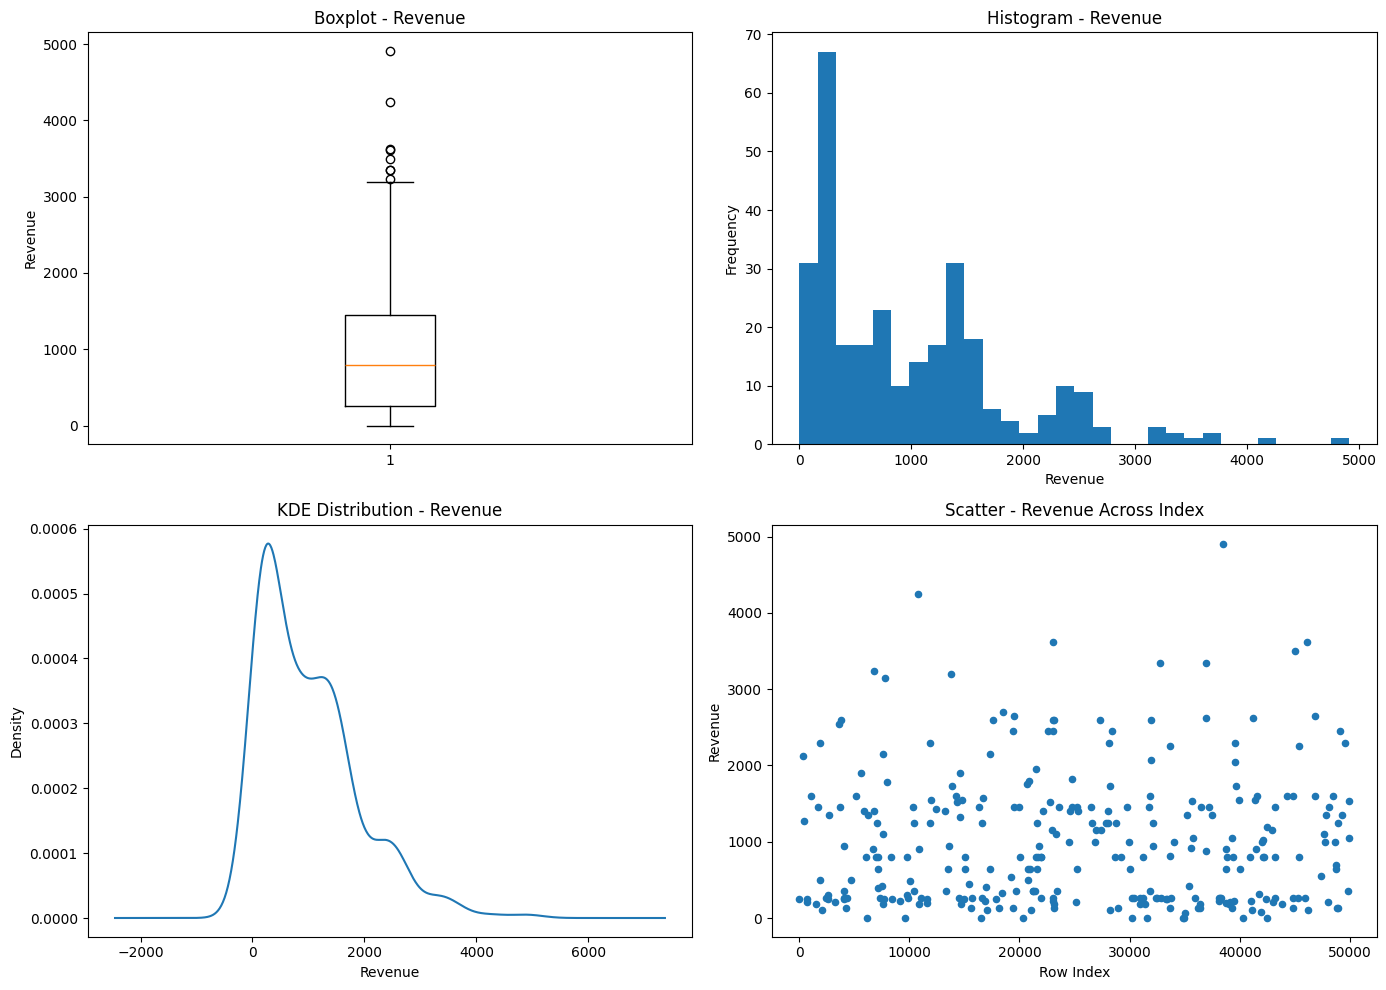

In [14]:
import matplotlib.pyplot as plt

# ---- Select the revenue column ----
rev = df_ext["revenue"]

# ---- Create figure space ----
plt.figure(figsize=(14, 10))

# ---------------------------
# 1) BOX PLOT
# ---------------------------
plt.subplot(2, 2, 1)
plt.boxplot(rev.dropna(), vert=True)
plt.title("Boxplot - Revenue")
plt.ylabel("Revenue")

# ---------------------------
# 2) HISTOGRAM
# ---------------------------
plt.subplot(2, 2, 2)
plt.hist(rev.dropna(), bins=30)
plt.title("Histogram - Revenue")
plt.xlabel("Revenue")
plt.ylabel("Frequency")

# ---------------------------
# 3) KDE / DISTRIBUTION
# ---------------------------
plt.subplot(2, 2, 3)
rev.dropna().plot(kind="kde")
plt.title("KDE Distribution - Revenue")
plt.xlabel("Revenue")

# ---------------------------
# 4) SCATTER PLOT (INDEX vs VALUE)
# ---------------------------
plt.subplot(2, 2, 4)
plt.scatter(rev.index, rev, s=20)
plt.title("Scatter - Revenue Across Index")
plt.xlabel("Row Index")
plt.ylabel("Revenue")

# -------- Show all plots --------
plt.tight_layout()
plt.show()


In [15]:
# =========================================================
# CREATE CLEAN DATAFRAME FOR DATA WAREHOUSE
# Drops ONLY rows marked as bad quality (Y)
# =========================================================

df_clean = df[df["flag_bad_data"] == "N"].copy()

print("\nRows before cleaning:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Rows removed:", len(df) - len(df_clean))

print("\nClean dataframe head:\n")
print(df_clean.head().to_markdown(index=False))

print("\nClean dataframe info:\n")
print(df_clean.info())




Rows before cleaning: 47054
Rows after cleaning: 47042
Rows removed: 12

Clean dataframe head:

| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_id   |   revenue 

In [16]:
# =========================================================
# CREATE FINAL CLEAN DATAFRAME (GOOD ROWS ONLY)
# =========================================================

# Keep only rows without bad data
df_clean = df[df["flag_bad_data"] == "N"].copy()

print("\nRows before cleaning:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Rows removed:", len(df) - len(df_clean))


# =========================================================
# DROP UNUSED COLUMNS IN THE CLEAN DATA
# =========================================================

cols_to_drop = ["product_feel", "product_size"]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

print("\nDropped columns:", cols_to_drop)


# =========================================================
# SHOW CLEANED DATAFRAME (HEAD + INFO)
# =========================================================

print("\nClean dataframe head:")
print(df_clean.head().to_markdown(index=False))

print("\nClean dataframe info:")
df_clean.info()



Rows before cleaning: 47054
Rows after cleaning: 47042
Rows removed: 12

Dropped columns: ['product_feel', 'product_size']

Clean dataframe head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_i

In [17]:
print(df_clean.columns.tolist())


['client_id', 'page_url', 'referrer', 'timestamp', 'event_name', 'event_data', 'user_agent', 'event_date', 'event_time', 'event_hour', 'event_weekday', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_content', 'utm_term', 'google_click_id', 'facebook_click_id', 'microsoft_click_id', 'google_wbraid', 'google_gbraid', 'mattress_type', 'product_color', 'product_variant', 'checkout_cart_id', 'checkout_queue_token', 'product_type', 'transaction_id', 'revenue', 'items', 'item_id', 'item_name', 'item_variant', 'item_quantity', 'item_price', 'item_type', 'item_size', 'dim_width_in', 'dim_length_in', 'dim_height_in', 'browser', 'ua_os', 'ua_device', 'ua_engine', 'flag_invalid_event_date', 'flag_missing_revenue_checkout', 'flag_revenue_on_non_checkout', 'flag_transactionid_no_revenue', 'flag_duplicate_transaction_id', 'flag_missing_timestamp', 'flag_missing_event_name', 'flag_missing_client_id', 'flag_missing_page_url_on_view', 'flag_suspicious_timestamp', 'flag_empty_utm_fields', 'flag_invalid

In [18]:
import pandas as pd
import numpy as np

# ==========================================================
# 0. STAGE RAW EVENTS
# ==========================================================
stg_raw_events = df_clean.copy()

# Define marketing columns
utm_cols = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]
click_cols = ["google_click_id", "facebook_click_id",
              "microsoft_click_id", "google_wbraid", "google_gbraid"]

# Standardize dtypes for UTM and click columns to avoid merge errors
for col in utm_cols + click_cols:
    if col in stg_raw_events.columns:
        stg_raw_events[col] = stg_raw_events[col].astype("string")

print("=== STG_RAW_EVENTS (preview) ===")
print(stg_raw_events.head())
stg_raw_events.info()


import pandas as pd
import numpy as np

# ==========================================================
# 0. STAGE RAW EVENTS
# ==========================================================
stg_raw_events = df_clean.copy()

# Marketing columns explicitly
utm_cols = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]
click_cols = ["google_click_id", "facebook_click_id",
              "microsoft_click_id", "google_wbraid", "google_gbraid"]

# Standardize dtypes for all UTM and click columns to string
for col in utm_cols + click_cols:
    if col in stg_raw_events.columns:
        stg_raw_events[col] = stg_raw_events[col].astype("string")

print("=== STG_RAW_EVENTS (preview) ===")
print(stg_raw_events.head())
stg_raw_events.info()


# ==========================================================
# 1. SESSIONIZATION + FORWARD-FILL MARKETING TAGS PER CLIENT
# ==========================================================
events = stg_raw_events.sort_values(["client_id", "timestamp"]).copy()

# Forward-fill UTM and click IDs within each client timeline
for col in utm_cols + click_cols:
    if col in events.columns:
        events[col + "_filled"] = (
            events
            .groupby("client_id")[col]
            .ffill()
        )

# Sessionization logic
timeout = pd.Timedelta(minutes=30)
events["prev_ts"] = events.groupby("client_id")["timestamp"].shift(1)
events["gap"] = events["timestamp"] - events["prev_ts"]
events["new_session"] = events["prev_ts"].isna() | (events["gap"] > timeout)

events["session_index"] = events["new_session"].cumsum()
events["session_id"] = "sess_" + events["session_index"].astype(str)

stg_with_sessions = events.drop(columns=["prev_ts", "gap", "new_session"])

print("\n=== STG_WITH_SESSIONS (preview) ===")
print(stg_with_sessions.head())
stg_with_sessions.info()


# ==========================================================
# 2. DIM_USERS
# ==========================================================
dim_users = (
    stg_with_sessions
    .groupby("client_id")
    .agg(
        first_seen=("timestamp", "min"),
        last_seen=("timestamp", "max"),
        total_events=("event_name", "count"),
        total_sessions=("session_id", "nunique"),
        total_revenue=("revenue", "sum")
    )
    .reset_index()
)

print("\n=== DIM_USERS (preview) ===")
print(dim_users.head())
dim_users.info()


# ==========================================================
# 3. FACT_SESSIONS
# ==========================================================
fact_sessions = (
    stg_with_sessions
    .groupby("session_id")
    .agg(
        client_id=("client_id", "first"),
        session_start=("timestamp", "min"),
        session_end=("timestamp", "max"),
        event_count=("event_name", "count"),
        pageview_count=("event_name", lambda x: (x == "page_viewed").sum()),
        order_count=("transaction_id", lambda x: x.notna().nunique()),
        session_revenue=("revenue", "sum"),
        browser=("browser", "first"),
        os=("ua_os", "first"),
        device=("ua_device", "first")
    )
    .reset_index()
)

fact_sessions["session_duration_seconds"] = (
    fact_sessions["session_end"] - fact_sessions["session_start"]
).dt.total_seconds().fillna(0)

print("\n=== FACT_SESSIONS (preview) ===")
print(fact_sessions.head())
fact_sessions.info()


# ==========================================================
# 4. DIM_UTM  (actual UTM combinations seen in raw events)
# ==========================================================
dim_utm = (
    stg_raw_events[utm_cols]
    .dropna(how="all")          # keep only rows with at least one UTM present
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_utm["utm_id"] = dim_utm.index + 1

print("\n=== DIM_UTM (preview) ===")
print(dim_utm.head())
dim_utm.info()


# ==========================================================
# 5. DIM_CLICK_IDS  (actual click ID combinations seen)
# ==========================================================
dim_click_ids = (
    stg_raw_events[click_cols]
    .dropna(how="all")
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_click_ids["click_id_key"] = dim_click_ids.index + 1

print("\n=== DIM_CLICK_IDS (preview) ===")
print(dim_click_ids.head())
dim_click_ids.info()


# ==========================================================
# 6. FACT_ORDERS  (one row per transaction_id)
#    Uses forward-filled UTM/click data per client
# ==========================================================
order_events = events[
    (events["event_name"] == "checkout_completed")
    & (events["transaction_id"].notna())
].copy()

# Aggregate revenue per transaction
order_revenue = (
    order_events
    .groupby("transaction_id")["revenue"]
    .sum()
    .reset_index()
    .rename(columns={"revenue": "order_revenue"})
)

# One row per transaction (first checkout_completed row in time)
fact_orders = (
    order_events
    .sort_values("timestamp")
    .drop_duplicates("transaction_id", keep="first")
    .merge(order_revenue, on="transaction_id", how="left")
)

# Use forward-filled UTM/click for orders where direct values are missing
for col in utm_cols + click_cols:
    filled_col = col + "_filled"
    if filled_col in fact_orders.columns:
        fact_orders[col] = fact_orders[col].fillna(fact_orders[filled_col])

# Attach UTM and click dimension keys
if not dim_utm.empty:
    fact_orders = fact_orders.merge(dim_utm, on=utm_cols, how="left")

if not dim_click_ids.empty:
    fact_orders = fact_orders.merge(dim_click_ids, on=click_cols, how="left")

# Keep a compact set of columns for the orders fact
keep_cols_orders = [
    "transaction_id",
    "client_id",
    "timestamp",
    "event_date",
    "browser",
    "ua_os",
    "ua_device",
    "order_revenue",
] + utm_cols + click_cols + ["utm_id", "click_id_key"]

fact_orders = fact_orders[keep_cols_orders].rename(columns={
    "timestamp": "order_timestamp",
    "event_date": "order_date",
    "ua_os": "os",
    "ua_device": "device"
})

print("\n=== FACT_ORDERS (preview) ===")
print(fact_orders.head())
fact_orders.info()


# ==========================================================
# 7. FACT_ORDER_ITEMS  (line-item grain with marketing info)
# ==========================================================
item_events = events[
    events["transaction_id"].notna()
    & events["items"].notna()
].copy()

rows = []
for _, row in item_events.iterrows():
    items_list = row["items"]
    if not isinstance(items_list, list):
        continue

    base = row.to_dict()
    for item in items_list:
        rec = {
            "transaction_id": base.get("transaction_id"),
            "client_id": base.get("client_id"),
            "timestamp": base.get("timestamp"),
            "event_date": base.get("event_date"),
            "browser": base.get("browser"),
            "os": base.get("ua_os"),
            "device": base.get("ua_device"),
        }
        # forward-filled marketing at this event
        for col in utm_cols + click_cols:
            rec[col] = base.get(col + "_filled")

        # item details
        rec["item_id"] = item.get("item_id")
        rec["item_name"] = item.get("item_name")
        rec["item_variant"] = item.get("item_variant")
        rec["item_quantity"] = item.get("quantity")
        rec["item_price"] = item.get("item_price")
        rows.append(rec)

fact_order_items = pd.DataFrame(rows)

# Line revenue
fact_order_items["line_revenue"] = (
    fact_order_items["item_quantity"].fillna(0)
    * fact_order_items["item_price"].fillna(0)
)

# Attach dim keys; join on the UTM/click combos used above
if not dim_utm.empty:
    fact_order_items = fact_order_items.merge(dim_utm, on=utm_cols, how="left")

if not dim_click_ids.empty:
    fact_order_items = fact_order_items.merge(dim_click_ids, on=click_cols, how="left")

print("\n=== FACT_ORDER_ITEMS (preview) ===")
print(fact_order_items.head())
fact_order_items.info()


# ==========================================================
# 8. DIM_PRODUCTS (from item-level attributes)
# ==========================================================
product_cols = ["item_name", "item_variant", "item_type", "item_size"]

# Some item_type/item_size may not be present in your df; guard safely
existing_product_cols = [c for c in product_cols if c in stg_raw_events.columns]  # from raw
# Better: try to get them from fact_order_items if present there
existing_product_cols = [c for c in product_cols if c in fact_order_items.columns]

dim_products = (
    fact_order_items[existing_product_cols]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_products["product_id"] = dim_products.index + 1

print("\n=== DIM_PRODUCTS (preview) ===")
print(dim_products.head())
dim_products.info()

# Attach product_id back to fact_order_items
if not dim_products.empty:
    fact_order_items = fact_order_items.merge(dim_products, on=existing_product_cols, how="left")


# ==========================================================
# 9. DIM_ITEMS (item_id to product_id mapping)
# ==========================================================
dim_items = (
    fact_order_items[["item_id", "product_id"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("\n=== DIM_ITEMS (preview) ===")
print(dim_items.head())
dim_items.info()


# ==========================================================
# FINAL SHAPES
# ==========================================================
print("\n=== FINAL TABLE SHAPES ===")
print("stg_raw_events:", stg_raw_events.shape)
print("stg_with_sessions:", stg_with_sessions.shape)
print("dim_users:", dim_users.shape)
print("fact_sessions:", fact_sessions.shape)
print("dim_utm:", dim_utm.shape)
print("dim_click_ids:", dim_click_ids.shape)
print("dim_products:", dim_products.shape)
print("dim_items:", dim_items.shape)
print("fact_orders:", fact_orders.shape)
print("fact_order_items:", fact_order_items.shape)



=== STG_RAW_EVENTS (preview) ===
                 client_id                                           page_url  \
0  1740268798-lvfV1k5nHCN8  https://puffy.com/blogs/best-sleep/heating-pad...   
1  1740268852-ioJSoDq7hwNm  https://puffy.com/products/puffy-mattress?size...   
2  1740268767-SDGE_Skxg7P7  https://puffy.com/products/puffy-topper?feel=D...   
3  1739894111-Ck3AEc97wn-A  https://puffy.com/blogs/reviews/mattress-in-a-...   
4  1740264185-OFhxMErmemrD                                 https://puffy.com/   

                       referrer                        timestamp   event_name  \
0  https://source-afb1343a.com/ 2025-02-23 00:00:01.750000+00:00  page_viewed   
1                           NaN 2025-02-23 00:00:54.391000+00:00  page_viewed   
2  https://source-e34e0c2e.com/ 2025-02-23 00:01:07.615000+00:00  page_viewed   
3                           NaN 2025-02-23 00:01:08.642000+00:00  page_viewed   
4                           NaN 2025-02-23 00:02:08.395000+00:00  page_view

In [19]:
df_1 = _dntk.execute_sql(
  'SELECT\n  DATE(session_start) AS day,\n  COUNT(*) AS sessions,\n  SUM(order_count) AS total_orders,\n  SUM(session_revenue) AS revenue,\n  ROUND(AVG(session_revenue),2) AS revenue_per_session,\n  ROUND(100.0 * SUM(CASE WHEN order_count > 0 THEN 1 END) / COUNT(*), 2) AS conversion_rate_pct,\n  AVG(session_duration_seconds) AS avg_session_seconds,\n  AVG(event_count) AS avg_events_per_session\nFROM fact_sessions\nGROUP BY 1\nORDER BY 1;\n\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_1

,day,sessions,total_orders,revenue,revenue_per_session,conversion_rate_pct,avg_session_seconds,avg_events_per_session
0,2025-02-23,3375,3393.0,20757.0,6.15,100.0,47.870514,1.202667
1,2025-02-24,3091,3109.0,25108.6,8.12,100.0,39.766460,1.197671
2,2025-02-25,2824,2837.0,13543.0,4.80,100.0,43.079753,1.217068
3,2025-02-26,2552,2565.0,18629.0,7.30,100.0,45.591632,1.226881
4,2025-02-27,2788,2805.0,18393.0,6.60,100.0,34.878008,1.204806
5,2025-02-28,2568,2579.0,18773.0,7.31,100.0,56.029739,1.262461
6,2025-03-01,2799,2820.0,32834.0,11.73,100.0,52.433764,1.235441
7,2025-03-02,2957,2974.0,28221.0,9.54,100.0,52.764805,1.235036
8,2025-03-03,2965,2981.0,20504.8,6.92,100.0,46.829410,1.243170
9,2025-03-04,2779,2793.0,12415.0,4.47,100.0,39.822443,1.164088


In [20]:
df_2 = _dntk.execute_sql(
  'SELECT\n    CASE\n        WHEN google_click_id IS NOT NULL THEN \'google_ads\'\n        WHEN facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n        WHEN microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n        ELSE \'organic_or_unknown\'\n    END AS channel,\n\n    COUNT(DISTINCT transaction_id) AS orders,\n    SUM(order_revenue) AS revenue,\n    COUNT(DISTINCT google_click_id) FILTER (WHERE google_click_id IS NOT NULL) AS google_ads_count,\n    COUNT(DISTINCT facebook_click_id) FILTER (WHERE facebook_click_id IS NOT NULL) AS facebook_ads_count,\n    COUNT(DISTINCT microsoft_click_id) FILTER (WHERE microsoft_click_id IS NOT NULL) AS microsoft_ads_count\nFROM fact_orders\nGROUP BY 1\nORDER BY revenue DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_2

,channel,orders,revenue,google_ads_count,facebook_ads_count,microsoft_ads_count
0,organic_or_unknown,192,196568.4,0,0,0
1,google_ads,65,66293.0,62,0,1
2,microsoft_ads,22,31355.0,0,0,20
3,facebook_ads,1,245.0,0,1,0


In [21]:
df_3 = _dntk.execute_sql(
  'SELECT\n    order_date,\n    SUM(CASE WHEN click_id IS NOT NULL THEN 1 ELSE 0 END) AS ad_orders,\n    SUM(CASE WHEN click_id IS NULL THEN 1 ELSE 0 END) AS organic_orders,\n    SUM(order_revenue) AS total_revenue,\n    SUM(CASE WHEN click_id IS NOT NULL THEN order_revenue ELSE 0 END) AS ad_revenue,\n    SUM(CASE WHEN click_id IS NULL THEN order_revenue ELSE 0 END) AS organic_revenue\nFROM (\n    SELECT\n        order_date,\n        transaction_id,\n        order_revenue,\n        COALESCE(google_click_id, facebook_click_id, microsoft_click_id) AS click_id\n    FROM fact_orders\n) x\nGROUP BY order_date\nORDER BY order_date;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_3

,order_date,ad_orders,organic_orders,total_revenue,ad_revenue,organic_revenue
0,2025-02-23,3.0,18.0,20408.0,5093.0,15315.0
1,2025-02-24,5.0,20.0,25457.6,4795.0,20662.6
2,2025-02-25,6.0,9.0,13543.0,8414.0,5129.0
3,2025-02-26,3.0,11.0,18629.0,4197.0,14432.0
4,2025-02-27,8.0,11.0,18148.0,6462.0,11686.0
5,2025-02-28,6.0,12.0,18669.0,3176.0,15493.0
6,2025-03-01,9.0,19.0,33183.0,11564.0,21619.0
7,2025-03-02,8.0,14.0,28221.0,13671.0,14550.0
8,2025-03-03,9.0,13.0,20504.8,10607.0,9897.8
9,2025-03-04,4.0,14.0,12415.0,3278.0,9137.0


In [22]:
df_4 = _dntk.execute_sql(
  'SELECT\n    foi.event_date AS order_date,\n    foi.item_name AS product_type,\n    CASE\n        WHEN foi.google_click_id IS NOT NULL THEN \'google_ads\'\n        WHEN foi.facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n        WHEN foi.microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n        ELSE \'organic_or_unknown\'\n    END AS channel,\n    SUM(foi.line_revenue) AS revenue,\n    COUNT(*) AS units_sold,\n    COUNT(DISTINCT foi.transaction_id) AS orders\nFROM fact_order_items foi\nGROUP BY 1, 2, 3\nORDER BY order_date, revenue DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_4

,order_date,product_type,channel,revenue,units_sold,orders
0,2025-02-23,Puffy Lux Mattress,organic_or_unknown,5846.0,4,4
1,2025-02-23,Puffy Royal Mattress,google_ads,4848.0,2,2
2,2025-02-23,Puffy Cloud Mattress,organic_or_unknown,3546.0,4,4
3,2025-02-23,Puffy Royal Mattress,organic_or_unknown,2599.0,1,1
4,2025-02-23,Puffy Deluxe Mattress Topper,organic_or_unknown,1470.0,6,6
5,2025-02-23,Puffy Sterling Bed Frame,organic_or_unknown,934.0,1,1
6,2025-02-23,Puffy Signature Pillow,organic_or_unknown,510.0,2,2
7,2025-02-23,Puffy Signature Sheets Set,organic_or_unknown,358.0,2,2
8,2025-02-23,Puffy Signature Mattress Protector,organic_or_unknown,256.0,2,2
9,2025-02-23,Puffy Deluxe Mattress Topper,facebook_ads,245.0,1,1


In [23]:
df_5 = _dntk.execute_sql(
  'WITH items_with_channel AS (\n    SELECT\n        event_date,\n        CASE\n            WHEN google_click_id IS NOT NULL THEN \'google_ads\'\n            WHEN facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n            WHEN microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n            ELSE \'organic_or_unknown\'\n        END AS channel,\n        line_revenue,\n        transaction_id\n    FROM fact_order_items\n)\nSELECT\n    event_date AS order_date,\n    channel,\n    SUM(line_revenue) AS revenue,\n    COUNT(DISTINCT transaction_id) AS orders\nFROM items_with_channel\nGROUP BY event_date, channel\nORDER BY order_date, channel;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_5

,order_date,channel,revenue,orders
0,2025-02-23,facebook_ads,245.0,1
1,2025-02-23,google_ads,4848.0,2
2,2025-02-23,organic_or_unknown,15519.0,18
3,2025-02-24,google_ads,3996.0,4
4,2025-02-24,microsoft_ads,799.0,1
5,2025-02-24,organic_or_unknown,21084.2,20
6,2025-02-25,google_ads,7615.0,5
7,2025-02-25,microsoft_ads,799.0,1
8,2025-02-25,organic_or_unknown,5129.0,9
9,2025-02-26,google_ads,5721.0,4


In [24]:
df_6 = _dntk.execute_sql(
  'WITH items_with_channel AS (\n    SELECT\n        event_date,\n        item_name,\n        CASE\n            WHEN google_click_id IS NOT NULL THEN \'google_ads\'\n            WHEN facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n            WHEN microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n            ELSE \'organic_or_unknown\'\n        END AS channel,\n        line_revenue,\n        transaction_id\n    FROM fact_order_items\n),\ndaily_product AS (\n    SELECT\n        event_date AS order_date,\n        channel,\n        item_name,\n        SUM(line_revenue) AS revenue,\n        COUNT(DISTINCT transaction_id) AS orders\n    FROM items_with_channel\n    GROUP BY event_date, channel, item_name\n),\nranked AS (\n    SELECT\n        order_date,\n        channel,\n        item_name,\n        revenue,\n        orders,\n        ROW_NUMBER() OVER (\n            PARTITION BY order_date, channel\n            ORDER BY revenue DESC\n        ) AS rn\n    FROM daily_product\n)\nSELECT\n    order_date,\n    channel,\n    item_name,\n    revenue,\n    orders\nFROM ranked\nWHERE rn = 1\nORDER BY order_date, revenue DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_6

,order_date,channel,item_name,revenue,orders
0,2025-02-23,organic_or_unknown,Puffy Lux Mattress,5846.0,4
1,2025-02-23,google_ads,Puffy Royal Mattress,4848.0,2
2,2025-02-23,facebook_ads,Puffy Deluxe Mattress Topper,245.0,1
3,2025-02-24,organic_or_unknown,Puffy Lux Mattress,6995.0,5
4,2025-02-24,google_ads,Puffy Royal Mattress,1899.0,1
5,2025-02-24,microsoft_ads,Puffy Lux Mattress,799.0,1
6,2025-02-25,google_ads,Puffy Monarch Mattress,3049.0,1
7,2025-02-25,organic_or_unknown,Puffy Lux Mattress,2398.0,2
8,2025-02-25,microsoft_ads,Puffy Lux Mattress,799.0,1
9,2025-02-26,organic_or_unknown,Puffy Lux Mattress,6096.0,4


In [25]:
df_7 = _dntk.execute_sql(
  '-- ROAS PER CHANNEL\n-- This metric shows which channel (Google, Facebook, Microsoft, Organic)\n-- generates the highest revenue per order.\n-- It is the core performance indicator for attribution effectiveness.\n\nWITH channelized AS (\n    SELECT\n        transaction_id,\n        order_revenue,\n        CASE\n            WHEN google_click_id IS NOT NULL THEN \'google_ads\'\n            WHEN facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n            WHEN microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n            ELSE \'organic_or_unknown\'\n        END AS channel\n    FROM fact_orders\n)\nSELECT\n    channel,\n    COUNT(transaction_id) AS orders,\n    SUM(order_revenue) AS revenue,\n    SUM(order_revenue) / COUNT(transaction_id) AS roas_proxy\nFROM channelized\nGROUP BY channel\nORDER BY roas_proxy DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_7

,channel,orders,revenue,roas_proxy
0,microsoft_ads,22,31355.0,1425.227273
1,organic_or_unknown,192,196568.4,1023.793750
2,google_ads,65,66293.0,1019.892308
3,facebook_ads,1,245.0,245.000000


In [26]:
df_8 = _dntk.execute_sql(
  '-- LTV BY CHANNEL\n-- This shows which acquisition channel brings the highest-LTV customers.\n-- Helps determine where budget should be increased or reduced.\n\nWITH user_channel AS (\n    SELECT\n        client_id,\n        CASE\n            WHEN google_click_id IS NOT NULL THEN \'google_ads\'\n            WHEN facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n            WHEN microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n            ELSE \'organic_or_unknown\'\n        END AS channel\n    FROM fact_orders\n),\nuser_ltv AS (\n    SELECT client_id, total_revenue\n    FROM dim_users\n)\nSELECT\n    uc.channel,\n    AVG(ul.total_revenue) AS avg_ltv,\n    SUM(ul.total_revenue) AS total_value,\n    COUNT(*) AS users\nFROM user_channel uc\nJOIN user_ltv ul USING (client_id)\nGROUP BY uc.channel\nORDER BY avg_ltv DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_8

,channel,avg_ltv,total_value,users
0,microsoft_ads,1687.954545,37135.0,22
1,google_ads,1117.092308,72611.0,65
2,organic_or_unknown,1005.168750,192992.4,192
3,facebook_ads,245.000000,245.0,1


In [27]:
df_9 = _dntk.execute_sql(
  '-- AVERAGE ORDER SIZE (AOV) AND ITEMS PER ORDER BY CHANNEL\n-- Identifies whether certain channels drive higher-value or larger multi-item carts.\n\nWITH order_item_count AS (\n    SELECT\n        transaction_id,\n        COUNT(*) AS items_in_order\n    FROM fact_order_items\n    GROUP BY transaction_id\n),\norders_with_channel AS (\n    SELECT\n        fo.transaction_id,\n        fo.order_revenue,\n        CASE\n            WHEN fo.google_click_id IS NOT NULL THEN \'google_ads\'\n            WHEN fo.facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n            WHEN fo.microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n            ELSE \'organic_or_unknown\'\n        END AS channel,\n        oic.items_in_order\n    FROM fact_orders fo\n    LEFT JOIN order_item_count oic USING (transaction_id)\n)\nSELECT\n    channel,\n    AVG(items_in_order) AS avg_items_per_order,\n    AVG(order_revenue) AS avg_order_value\nFROM orders_with_channel\nGROUP BY channel\nORDER BY avg_order_value DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_9

,channel,avg_items_per_order,avg_order_value
0,microsoft_ads,1.409091,1425.227273
1,organic_or_unknown,1.229167,1023.793750
2,google_ads,1.169231,1019.892308
3,facebook_ads,1.000000,245.000000


In [28]:
df_10 = _dntk.execute_sql(
  '-- Monthly Cohort Revenue Retention\nSELECT\n    DATE_TRUNC(\'month\', u.first_seen) AS cohort_month,\n    DATE_TRUNC(\'month\', foi.event_date) AS activity_month,\n    COUNT(DISTINCT u.client_id) AS active_users,\n    SUM(foi.line_revenue) AS revenue\nFROM dim_users u\nLEFT JOIN fact_order_items foi\n    ON u.client_id = foi.client_id\nGROUP BY 1,2\nORDER BY cohort_month, activity_month;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_10

,cohort_month,activity_month,active_users,revenue
0,2025-02-01 00:00:00+00:00,2025-02-01,109,121210.2
1,2025-02-01 00:00:00+00:00,2025-03-01,16,17845.0
2,2025-02-01 00:00:00+00:00,NaT,15996,NaN
3,2025-03-01 00:00:00+00:00,2025-03-01,151,106476.8
4,2025-03-01 00:00:00+00:00,NaT,18998,NaN


In [29]:
df_11 = _dntk.execute_sql(
  '-- -------------------------------------------------------------\n-- FIRST TOUCH VS LAST TOUCH ATTRIBUTION\n-- -------------------------------------------------------------\n-- First-touch = channel of user\'s earliest order_date\n-- Last-touch  = channel of user\'s latest order_date\n-- -------------------------------------------------------------\n\nSELECT\n    first_channel,\n    last_channel,\n    COUNT(DISTINCT transaction_id) AS orders,\n    SUM(order_revenue) AS revenue\nFROM (\n    SELECT\n        client_id,\n        transaction_id,\n        order_revenue,\n\n        -- First attribution channel by earliest order_date\n        FIRST_VALUE(channel) OVER(\n            PARTITION BY client_id\n            ORDER BY order_date\n        ) AS first_channel,\n\n        -- Last-touch attribution by latest order_date\n        LAST_VALUE(channel) OVER(\n            PARTITION BY client_id\n            ORDER BY order_date\n            RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING\n        ) AS last_channel\n\n    FROM (\n        SELECT\n            fo.client_id,\n            fo.transaction_id,\n            fo.order_revenue,\n            fo.order_date,                                 -- FIXED COLUMN\n            CASE\n                WHEN fo.google_click_id IS NOT NULL THEN \'google_ads\'\n                WHEN fo.facebook_click_id IS NOT NULL THEN \'facebook_ads\'\n                WHEN fo.microsoft_click_id IS NOT NULL THEN \'microsoft_ads\'\n                ELSE \'organic_or_unknown\'\n            END AS channel\n        FROM fact_orders fo\n    )\n)\nGROUP BY 1,2\nORDER BY revenue DESC;\n\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_11

,first_channel,last_channel,orders,revenue
0,organic_or_unknown,organic_or_unknown,192,196568.4
1,google_ads,google_ads,65,66293.0
2,microsoft_ads,microsoft_ads,22,31355.0
3,facebook_ads,facebook_ads,1,245.0


In [30]:
df_12 = _dntk.execute_sql(
  '-- -------------------------------------------------------------\n-- FUNNEL CONVERSION ANALYSIS\n-- -------------------------------------------------------------\n-- Funnel:\n--   1. Session\n--   2. Product View (item_name IS NOT NULL)\n--   3. Checkout Started (checkout_cart_id not null)\n--   4. Order Completed (transaction_id not null)\n-- Business value:\n--   • Identify biggest drop-off step\n--   • Measure overall conversion\n--   • Highlight stages for optimization\n-- -------------------------------------------------------------\n\nWITH steps AS (\n    SELECT\n        session_id,\n        MAX(CASE WHEN item_name IS NOT NULL THEN 1 END) AS viewed_product,\n        MAX(CASE WHEN checkout_cart_id IS NOT NULL THEN 1 END) AS checkout_started,\n        MAX(CASE WHEN transaction_id IS NOT NULL THEN 1 END) AS order_completed\n    FROM stg_with_sessions\n    GROUP BY 1\n)\nSELECT\n    COUNT(*) AS sessions,\n    SUM(viewed_product) AS product_views,\n    SUM(checkout_started) AS checkout_starts,\n    SUM(order_completed) AS completed_orders,\n    SUM(order_completed)::float / COUNT(*) AS session_to_order_rate\nFROM steps;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_12

,sessions,product_views,checkout_starts,completed_orders,session_to_order_rate
0,38263,280.0,37.0,280.0,0.007318


In [31]:
df_13 = _dntk.execute_sql(
  '-- -------------------------------------------------------------\n-- PRODUCT REVENUE CONTRIBUTION (PARETO)\n-- -------------------------------------------------------------\n-- Measures how much each product contributes to total revenue.\n-- Useful for:\n--   • Identifying the top 20% products generating 80% revenue\n--   • Inventory and marketing prioritization\n-- -------------------------------------------------------------\n\nWITH product_rev AS (\n    SELECT\n        item_name,\n        SUM(line_revenue) AS revenue\n    FROM fact_order_items\n    GROUP BY 1\n),\n ranked AS (\n    SELECT\n        item_name,\n        revenue,\n        revenue / (SELECT SUM(revenue) FROM product_rev) AS pct_contribution,\n        SUM(revenue) OVER(ORDER BY revenue DESC) /\n        (SELECT SUM(revenue) FROM product_rev) AS cum_pct\n    FROM product_rev\n)\nSELECT *\nFROM ranked\nORDER BY revenue DESC;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_13

,item_name,revenue,pct_contribution,cum_pct
0,Puffy Lux Mattress,96921.0,0.394739,0.394739
1,Puffy Royal Mattress,55774.0,0.227156,0.621894
2,Puffy Cloud Mattress,39023.0,0.158932,0.780827
3,Puffy Deluxe Mattress Topper,13684.0,0.055732,0.836559
4,Puffy Monarch Mattress,9397.0,0.038272,0.874831
5,Puffy Serenity Adjustable Base,8692.0,0.035401,0.910232
6,Puffy Signature Sheets Set,5728.0,0.023329,0.933561
7,Puffy Sterling Bed Frame,4925.0,0.020058,0.953619
8,Puffy Signature Mattress Protector,3072.0,0.012512,0.966131
9,Puffy Dusk Bed Frame,2587.0,0.010536,0.976667


ROC AUC: 0.9764261644000481
              precision    recall  f1-score   support

           0      0.996     0.987     0.992      9496
           1      0.215     0.486     0.298        70

    accuracy                          0.983      9566
   macro avg      0.606     0.736     0.645      9566
weighted avg      0.990     0.983     0.986      9566



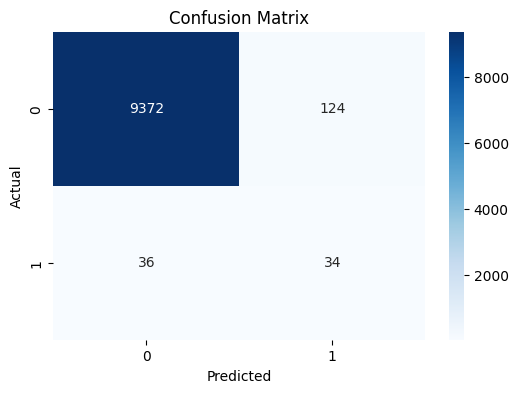

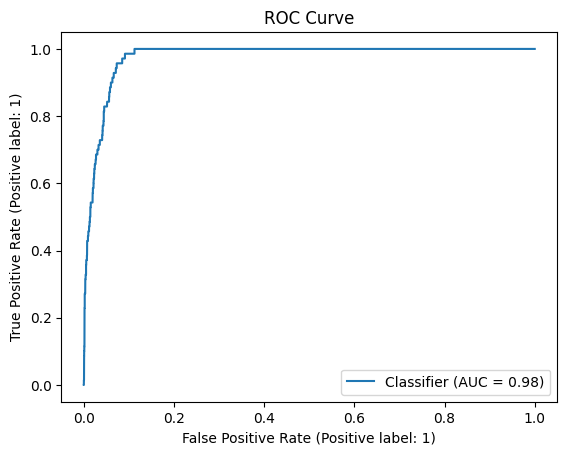

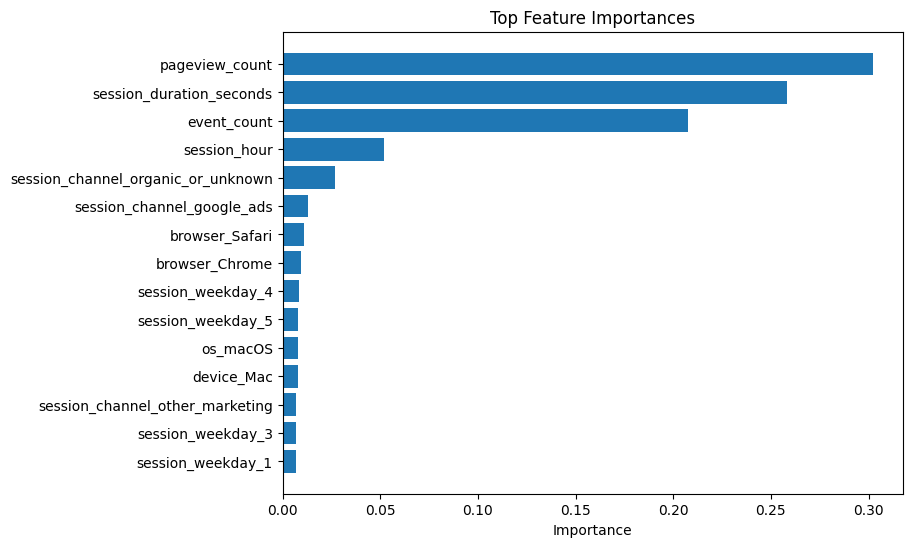

In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

# -------------------------------------------
# 1. BUILD A CLEAN, NO-LEAKAGE FEATURESET
# -------------------------------------------

sessions = fact_sessions.copy()
events = stg_with_sessions.copy()

# Target label
sessions["converted"] = (sessions["session_revenue"] > 0).astype(int)

# Time features
sessions["session_hour"] = sessions["session_start"].dt.hour
sessions["session_weekday"] = sessions["session_start"].dt.dayofweek

# -------------------------------------------
# 2. Derive CHANNEL per session
# -------------------------------------------

def detect_channel(group):
    if group["google_click_id"].notna().any():
        return "google_ads"
    if group["facebook_click_id"].notna().any():
        return "facebook_ads"
    if group["microsoft_click_id"].notna().any():
        return "microsoft_ads"
    if group[["utm_source","utm_medium","utm_campaign"]].notna().any().any():
        return "other_marketing"
    return "organic_or_unknown"

channel_map = (
    events.groupby("session_id")
    .apply(detect_channel)
    .reset_index(name="session_channel")
)

df = sessions.merge(channel_map, on="session_id", how="left")
df["session_channel"] = df["session_channel"].fillna("organic_or_unknown")

# -------------------------------------------
# 3. Select NON-LEAKING Features
# -------------------------------------------

numeric_features = [
    "event_count",
    "pageview_count",
    "session_duration_seconds",
    "session_hour",
]

categorical_features = [
    "browser",
    "os",
    "device",
    "session_channel",
    "session_weekday",
]

feature_cols = numeric_features + categorical_features

X = df[feature_cols]
y = df["converted"]

# -------------------------------------------
# 4. Train/Test Split
# -------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -------------------------------------------
# 5. Preprocessing + RandomForest Model
# -------------------------------------------

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

model = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42
    ))
])

# -------------------------------------------
# 6. Fit Model
# -------------------------------------------

model.fit(X_train, y_train)

# -------------------------------------------
# 7. Evaluate
# -------------------------------------------

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

# -------------------------------------------
# 8. Confusion Matrix Plot
# -------------------------------------------

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------------------
# 9. ROC Curve
# -------------------------------------------

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

# -------------------------------------------
# 10. Feature Importance
# -------------------------------------------

ohe = model.named_steps["prep"].named_transformers_["cat"]["ohe"]
ohe_features = ohe.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(ohe_features)
importances = model.named_steps["rf"].feature_importances_

# Top 15
idx = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(np.array(all_feature_names)[idx], importances[idx])
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.show()



In [33]:
import pandas as pd
import numpy as np
import smtplib
from email.mime.text import MIMEText

def run_monitoring(
    stg_raw_events,
    fact_sessions,
    dim_users,
    fact_orders,
    fact_order_items,
    dim_utm=None,
    dim_click_ids=None,
    run_date=None,
    send_email=False,
    email_to="dummy@puffy.com"
):
    """
    Run daily monitoring checks on the main warehouse tables.
    Returns a DataFrame with one row per check and prints a summary.
    Optionally sends an email with FAILED and WARN checks.
    """

    checks = []

    def add_check(name, value, status, threshold=None, details=None):
        checks.append({
            "check_name": name,
            "value": value,
            "status": status,
            "threshold_or_expectation": threshold,
            "details": details
        })

    # ----------------------------------------------------------
    # 0. Infer run_date from data if not provided
    # ----------------------------------------------------------
    if run_date is None:
        if "event_date" in stg_raw_events.columns:
            run_date = stg_raw_events["event_date"].max().normalize()
        else:
            run_date = pd.Timestamp.utcnow().normalize()

    # ----------------------------------------------------------
    # 1. Freshness checks
    # ----------------------------------------------------------
    max_event_ts = stg_raw_events["timestamp"].max()
    now_utc = pd.Timestamp.utcnow()
    freshness_hours = (now_utc - max_event_ts).total_seconds() / 3600.0

    add_check(
        name="freshness_hours_since_last_event",
        value=round(freshness_hours, 2),
        status="FAIL" if freshness_hours > 36 else "PASS",
        threshold="<= 36 hours",
        details=f"Max event timestamp: {max_event_ts}"
    )

    # ----------------------------------------------------------
    # 2. Volume checks (today vs last 7 days)
    # ----------------------------------------------------------
    if "event_date" in stg_raw_events.columns:
        daily_counts = (
            stg_raw_events
            .groupby("event_date")
            .size()
            .rename("events")
            .reset_index()
        )

        today_events = daily_counts.loc[
            daily_counts["event_date"] == run_date, "events"
        ]
        today_events = int(today_events.iloc[0]) if not today_events.empty else 0

        last_7_mask = (daily_counts["event_date"] < run_date) & \
                      (daily_counts["event_date"] >= run_date - pd.Timedelta(days=7))
        last_7 = daily_counts.loc[last_7_mask, "events"]

        if len(last_7) >= 3:
            mean_7 = last_7.mean()
            if mean_7 > 0:
                pct_of_mean = today_events / mean_7
                status = "PASS" if 0.5 <= pct_of_mean <= 1.5 else "WARN"
                details = f"7-day mean={mean_7:.1f}, today={today_events}, ratio={pct_of_mean:.2f}"
            else:
                pct_of_mean = np.nan
                status = "PASS"
                details = "7-day mean is zero or missing."
        else:
            pct_of_mean = np.nan
            status = "PASS"
            details = "Insufficient history for 7-day comparison."

        add_check(
            name="raw_event_volume_vs_7day_mean",
            value=pct_of_mean,
            status=status,
            threshold="between 0.5x and 1.5x of 7-day mean",
            details=details
        )

    # ----------------------------------------------------------
    # 3. Required field null rates
    # ----------------------------------------------------------
    def null_rate(df, col):
        return float(df[col].isna().mean()) if col in df.columns else np.nan

    required_stg_cols = ["client_id", "timestamp", "event_name", "page_url"]
    for col in required_stg_cols:
        rate = null_rate(stg_raw_events, col)
        status = "PASS" if (not np.isnan(rate) and rate <= 0.01) else "WARN"
        add_check(
            name=f"null_rate_stg_raw_events.{col}",
            value=round(rate, 4) if not np.isnan(rate) else None,
            status=status,
            threshold="<= 1%",
            details=None
        )

    # fact_orders required columns
    required_fact_orders = ["transaction_id", "order_revenue"]
    for col in required_fact_orders:
        if col not in fact_orders.columns:
            add_check(
                name=f"missing_column_fact_orders.{col}",
                value=None,
                status="FAIL",
                threshold="Column must exist",
                details="Column not found"
            )
            continue

        rate = null_rate(fact_orders, col)
        status = "PASS" if rate == 0 else "FAIL"
        add_check(
            name=f"null_rate_fact_orders.{col}",
            value=round(rate, 4),
            status=status,
            threshold="0%",
            details=None
        )

    # fact_order_items required columns
    required_items_cols = ["transaction_id", "item_id", "item_name", "quantity", "item_price", "line_revenue"]
    for col in required_items_cols:
        if col not in fact_order_items.columns:
            add_check(
                name=f"missing_column_fact_order_items.{col}",
                value=None,
                status="FAIL",
                threshold="Column must exist",
                details="Column not found"
            )
            continue

        rate = null_rate(fact_order_items, col)
        threshold_str = "0%" if col in ["transaction_id", "item_id", "item_name", "quantity", "line_revenue"] else "<= 5%"
        if col in ["transaction_id", "item_id", "item_name", "quantity", "line_revenue"]:
            status = "PASS" if rate == 0 else "FAIL"
        else:
            status = "PASS" if rate <= 0.05 else "WARN"

        add_check(
            name=f"null_rate_fact_order_items.{col}",
            value=round(rate, 4),
            status=status,
            threshold=threshold_str,
            details=None
        )

    # ----------------------------------------------------------
    # 4. Revenue sanity checks
    # ----------------------------------------------------------
    if "order_revenue" in fact_orders.columns:
        negative_orders = (fact_orders["order_revenue"] < 0).sum()
        add_check(
            name="negative_order_revenue_count",
            value=int(negative_orders),
            status="FAIL" if negative_orders > 0 else "PASS",
            threshold="0 negative rows",
            details=None
        )

    if "line_revenue" in fact_order_items.columns:
        negative_lines = (fact_order_items["line_revenue"] < 0).sum()
        add_check(
            name="negative_line_revenue_count",
            value=int(negative_lines),
            status="FAIL" if negative_lines > 0 else "PASS",
            threshold="0 negative rows",
            details=None
        )

    # Check line_revenue ~= quantity * item_price
    if set(["quantity", "item_price", "line_revenue"]).issubset(fact_order_items.columns):
        tmp = fact_order_items.dropna(subset=["quantity", "item_price", "line_revenue"]).copy()
        tmp["recomputed"] = tmp["quantity"] * tmp["item_price"]
        tmp["abs_diff"] = (tmp["recomputed"] - tmp["line_revenue"]).abs()
        bad_rows = (tmp["abs_diff"] > 0.01).sum()
        frac_bad = bad_rows / len(tmp) if len(tmp) > 0 else 0.0

        add_check(
            name="line_revenue_mismatch_fraction",
            value=round(frac_bad, 4),
            status="PASS" if frac_bad <= 0.01 else "WARN",
            threshold="<= 1% of rows",
            details=f"{bad_rows} rows with mismatch"
        )

    # ----------------------------------------------------------
    # 5. Referential integrity checks
    # ----------------------------------------------------------
    # fact_sessions.client_id in dim_users
    if set(["client_id"]).issubset(fact_sessions.columns) and "client_id" in dim_users.columns:
        missing_clients = pd.Index(fact_sessions["client_id"].unique()).difference(dim_users["client_id"].unique())
        count_missing_clients = len(missing_clients)
        add_check(
            name="fact_sessions_client_id_not_in_dim_users",
            value=int(count_missing_clients),
            status="FAIL" if count_missing_clients > 0 else "PASS",
            threshold="0 missing client_ids",
            details=None if count_missing_clients == 0 else f"Example missing: {list(missing_clients[:5])}"
        )

    # fact_order_items.transaction_id in fact_orders
    if "transaction_id" in fact_order_items.columns and "transaction_id" in fact_orders.columns:
        missing_tx = pd.Index(fact_order_items["transaction_id"].unique()).difference(
            fact_orders["transaction_id"].unique()
        )
        count_missing_tx = len(missing_tx)
        add_check(
            name="fact_order_items_tx_not_in_fact_orders",
            value=int(count_missing_tx),
            status="FAIL" if count_missing_tx > 0 else "PASS",
            threshold="0 missing transaction_ids",
            details=None if count_missing_tx == 0 else f"Example missing: {list(missing_tx[:5])}"
        )

    # order_revenue vs sum(line_revenue)
    if {"transaction_id", "order_revenue"}.issubset(fact_orders.columns) and \
       {"transaction_id", "line_revenue"}.issubset(fact_order_items.columns):

        items_sum = (
            fact_order_items
            .groupby("transaction_id")["line_revenue"]
            .sum()
            .reset_index()
            .rename(columns={"line_revenue": "item_sum"})
        )

        merged = fact_orders.merge(items_sum, on="transaction_id", how="left")
        merged["item_sum"] = merged["item_sum"].fillna(0)
        merged["abs_diff"] = (merged["order_revenue"] - merged["item_sum"]).abs()
        mask_pos = merged["order_revenue"] > 0
        merged.loc[mask_pos, "rel_diff"] = merged.loc[mask_pos, "abs_diff"] / merged.loc[mask_pos, "order_revenue"]

        bad_tx = merged[(merged["order_revenue"] > 0) & (merged["rel_diff"] > 0.02)]
        frac_bad_tx = len(bad_tx) / len(merged) if len(merged) > 0 else 0.0

        add_check(
            name="order_vs_items_revenue_mismatch_fraction",
            value=round(frac_bad_tx, 4),
            status="PASS" if frac_bad_tx <= 0.01 else "WARN",
            threshold="<= 1% of orders",
            details=f"{len(bad_tx)} orders with >2% mismatch"
        )

    # ----------------------------------------------------------
    # 6. Tracking coverage on orders
    # ----------------------------------------------------------
    tracking_cols = [c for c in ["utm_source", "google_click_id", "facebook_click_id", "microsoft_click_id"]
                     if c in fact_orders.columns]

    if tracking_cols:
        tracked_mask = fact_orders[tracking_cols].notna().any(axis=1)
        share_tracked = tracked_mask.mean()

        add_check(
            name="share_of_orders_with_any_tracking_id",
            value=round(float(share_tracked), 4),
            status="PASS" if share_tracked >= 0.6 else "WARN",
            threshold=">= 60% (example threshold)",
            details=None
        )

    # ----------------------------------------------------------
    # 7. Core business KPIs for the run_date
    # ----------------------------------------------------------
    if "event_date" in fact_sessions.columns:
        sessions_today = fact_sessions.loc[
            fact_sessions["event_date"] == run_date, "session_id"
        ].nunique()
    else:
        sessions_today = fact_sessions.loc[
            fact_sessions["session_start"].dt.normalize() == run_date, "session_id"
        ].nunique()

    orders_today = fact_orders.loc[
        fact_orders["order_date"].dt.normalize() == run_date, "transaction_id"
    ].nunique() if "order_date" in fact_orders.columns else None

    revenue_today = fact_orders.loc[
        fact_orders["order_date"].dt.normalize() == run_date, "order_revenue"
    ].sum() if "order_date" in fact_orders.columns else None

    conv_rate = (orders_today / sessions_today) if sessions_today and sessions_today > 0 else None
    aov = (revenue_today / orders_today) if orders_today and orders_today > 0 else None

    add_check(
        name="kpi_sessions_today",
        value=int(sessions_today) if sessions_today is not None else None,
        status="PASS",
        threshold="> 0 sessions expected",
        details=str(run_date.date())
    )

    add_check(
        name="kpi_orders_today",
        value=int(orders_today) if orders_today is not None else None,
        status="PASS",
        threshold=">= 0 orders",
        details=str(run_date.date())
    )

    add_check(
        name="kpi_revenue_today",
        value=float(revenue_today) if revenue_today is not None else None,
        status="PASS",
        threshold=">= 0 revenue",
        details=str(run_date.date())
    )

    add_check(
        name="kpi_conversion_rate_today",
        value=float(conv_rate) if conv_rate is not None else None,
        status="PASS",
        threshold="monitor trend vs history",
        details=str(run_date.date())
    )

    add_check(
        name="kpi_aov_today",
        value=float(aov) if aov is not None else None,
        status="PASS",
        threshold="monitor trend vs history",
        details=str(run_date.date())
    )

    # ----------------------------------------------------------
    # Final summary and printing
    # ----------------------------------------------------------
    checks_df = pd.DataFrame(checks)

    print("=== DATA QUALITY AND KPI MONITORING SUMMARY (ALL CHECKS) ===")
    print(checks_df)

    failed = checks_df[checks_df["status"] == "FAIL"]
    warned = checks_df[checks_df["status"] == "WARN"]

    print("\n=== FAILED CHECKS ===")
    if failed.empty:
        print("None")
    else:
        print(failed)

    print("\n=== WARN CHECKS ===")
    if warned.empty:
        print("None")
    else:
        print(warned)

    any_fail = not failed.empty
    any_warn = not warned.empty

    # ----------------------------------------------------------
    # Optional email notification
    # ----------------------------------------------------------
    if send_email and (any_fail or any_warn):
        subject = f"[Puffy Data Quality] Daily Monitoring Report for {run_date.date()}"
        body_lines = []

        body_lines.append("Daily data quality monitoring report.")
        body_lines.append(f"Run date: {run_date.date()}")
        body_lines.append("")

        if any_fail:
            body_lines.append("FAILED checks:")
            for _, row in failed.iterrows():
                body_lines.append(
                    f"- {row['check_name']}: value={row['value']} "
                    f"(expected {row['threshold_or_expectation']}). "
                    f"Details: {row['details']}"
                )
            body_lines.append("")

        if any_warn:
            body_lines.append("WARN checks:")
            for _, row in warned.iterrows():
                body_lines.append(
                    f"- {row['check_name']}: value={row['value']} "
                    f"(expected {row['threshold_or_expectation']}). "
                    f"Details: {row['details']}"
                )
            body_lines.append("")

        body_lines.append("")
        body_lines.append("This email is auto-generated from the daily ETL monitoring job.")

        email_body = "\n".join(body_lines)

        msg = MIMEText(email_body)
        msg["Subject"] = subject
        msg["From"] = "data-pipeline@puffy.com"  # example sender
        msg["To"] = email_to

        # You need to configure SMTP details for your environment.
        # This is a template you can adapt.
        try:
            smtp_host = "smtp.yourprovider.com"
            smtp_port = 587
            smtp_user = "your_smtp_user"
            smtp_pass = "your_smtp_password"

            with smtplib.SMTP(smtp_host, smtp_port) as server:
                server.starttls()
                server.login(smtp_user, smtp_pass)
                server.send_message(msg)

            print(f"\nEmail alert sent to {email_to}")
        except Exception as e:
            print("\nFailed to send email alert:")
            print(e)

    return checks_df